# Part I: Data Preparation and Analysis

## Add all necessary imports

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

## Load the datasets

In [60]:
train_data = pd.read_csv('./dataset_Seminar4/train_data.csv')
test_data = pd.read_csv('./dataset_Seminar4/test_data.csv')

train_data.describe()

,LocationNumber,RSSI,TxLinkSpeed,RxLinkSpeed,MainAPConnect,TxThroughput,AvgPingLatency
count,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000
mean,18.151161,-62.364212,491.264874,460.954107,0.913958,12.988920,54.771372
std,10.338002,9.442463,240.868700,251.600115,0.280430,4.413973,8.735672
min,1.000000,-79.040000,33.240000,-12.530000,0.000000,0.780000,39.300000
25%,9.000000,-70.360000,273.200000,249.127500,1.000000,11.320000,48.940000
50%,18.000000,-62.910000,476.635000,396.480000,1.000000,14.790000,52.290000
75%,27.000000,-53.790000,664.390000,656.422500,1.000000,15.980000,57.470000
max,36.000000,-37.020000,905.390000,911.000000,1.000000,19.160000,96.550000


##### From the describe() output, we can observe several key insights about our training data:
##### - RSSI values range from -79 to -37 dBm, with a mean of -62 dBm, indicating typical WiFi signal strength
##### - Link speeds (Tx/Rx) show high variability (33-905 Mbps) with means around 450-490 Mbps
##### - MainAPConnect is binary (0/1) with ~91% of connections being to the main AP
##### - TxThroughput ranges from 0.78 to 19.16 Mbps with a mean of 13 Mbps
##### - AvgPingLatency varies from 39 to 96ms with a mean of 55ms


## Make plots to understand the data

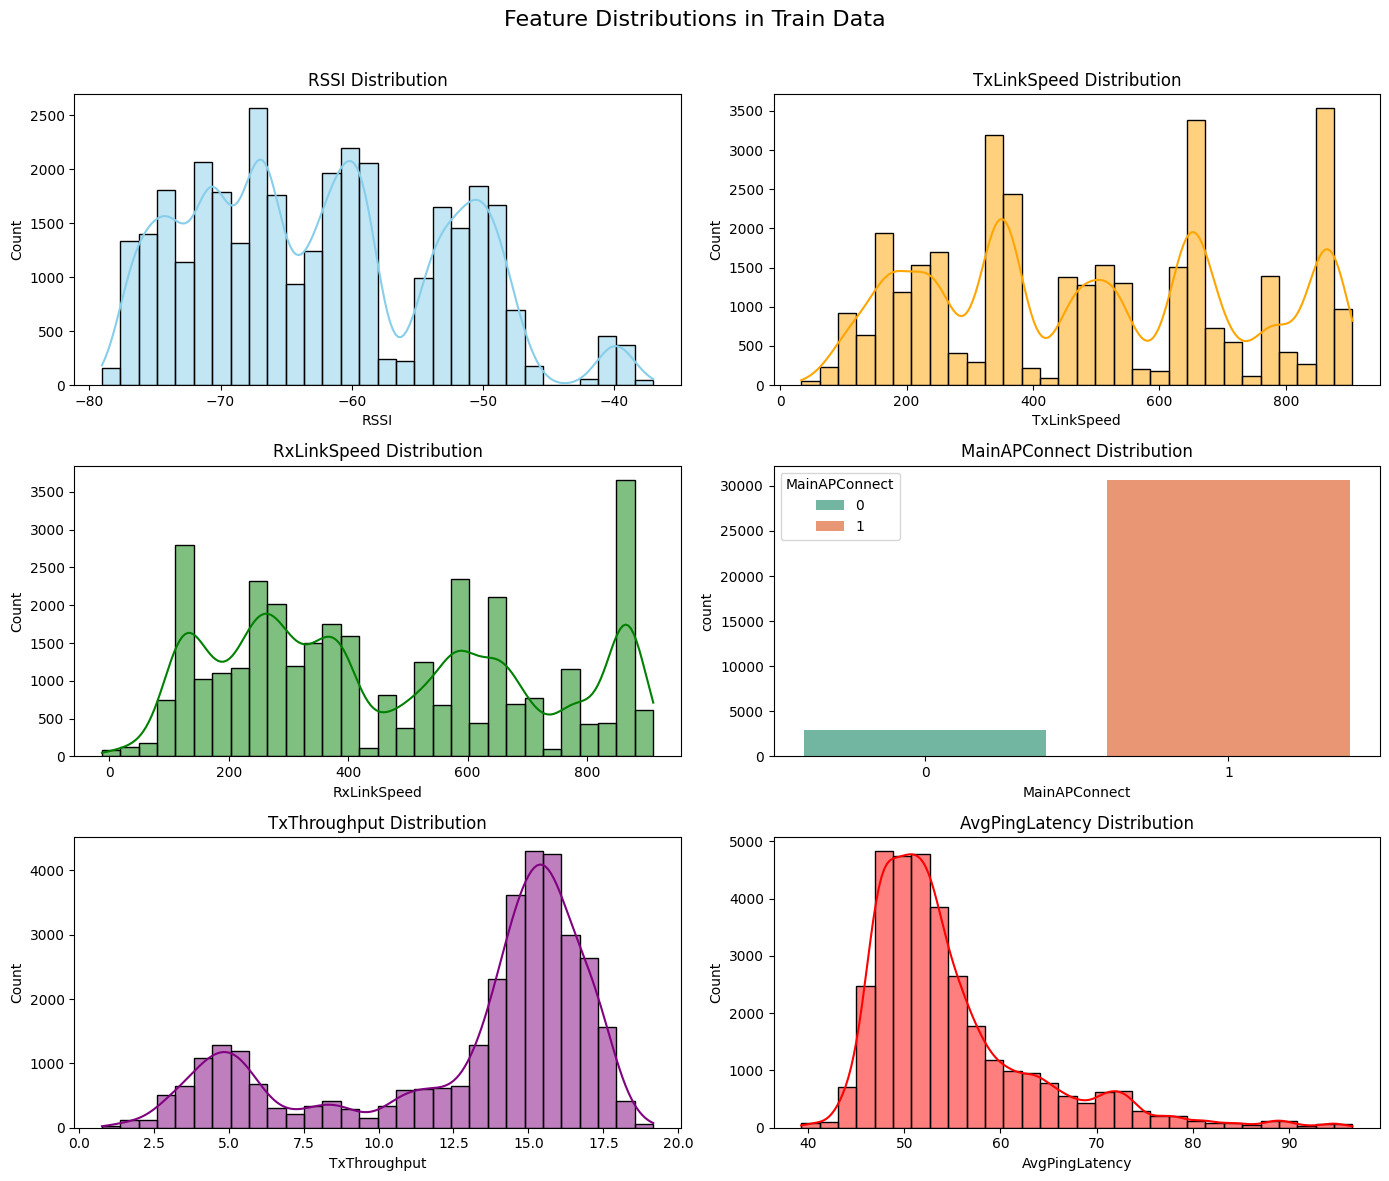

In [61]:
# For this we will one use the train_data.csv file as the test_data.csv file should be distributed similarly to the train one.

# Plot the distribution of each feature
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Feature Distributions in Train Data', fontsize=16)

# RSSI
sns.histplot(train_data['RSSI'], bins=30, kde=True, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('RSSI Distribution')

# TxLinkSpeed
sns.histplot(train_data['TxLinkSpeed'], bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('TxLinkSpeed Distribution')

# RxLinkSpeed
sns.histplot(train_data['RxLinkSpeed'], bins=30, kde=True, ax=axs[1, 0], color='green')
axs[1, 0].set_title('RxLinkSpeed Distribution')

# MainAPConnect
sns.countplot(x='MainAPConnect', data=train_data, ax=axs[1, 1], palette='Set2', hue='MainAPConnect')
axs[1, 1].set_title('MainAPConnect Distribution')

# TxThroughput
sns.histplot(train_data['TxThroughput'], bins=30, kde=True, ax=axs[2, 0], color='purple')
axs[2, 0].set_title('TxThroughput Distribution')

# AvgPingLatency
sns.histplot(train_data['AvgPingLatency'], bins=30, kde=True, ax=axs[2, 1], color='red')
axs[2, 1].set_title('AvgPingLatency Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



Correlation of features with TxThroughput:
LocationNumber    0.046687
RSSI              0.076853
TxLinkSpeed       0.044451
RxLinkSpeed       0.044280
MainAPConnect     0.321010
Name: TxThroughput, dtype: float64

Correlation of features with AvgPingLatency:
LocationNumber    0.322541
RSSI             -0.375971
TxLinkSpeed      -0.331170
RxLinkSpeed      -0.361945
MainAPConnect     0.028982
Name: AvgPingLatency, dtype: float64


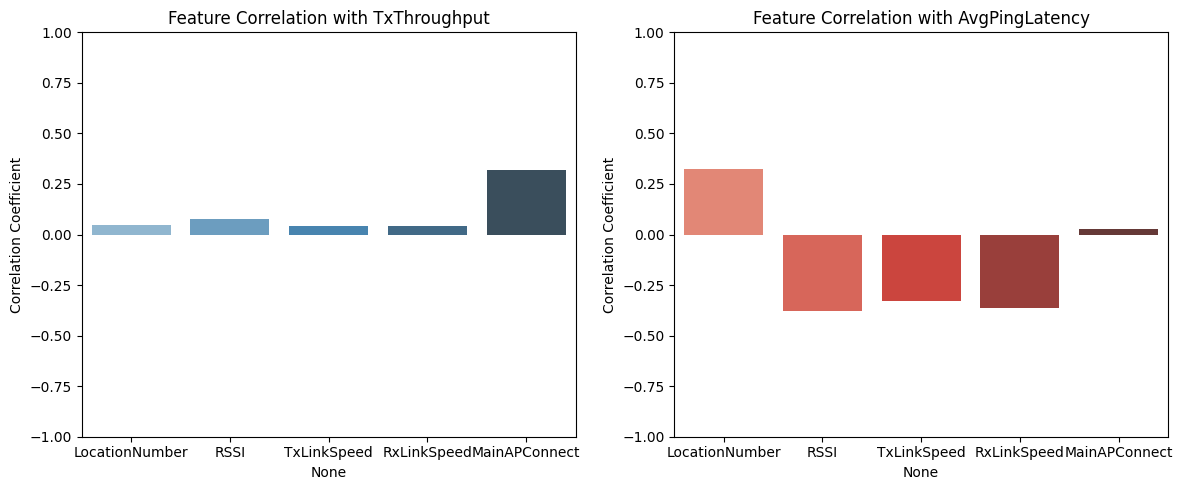

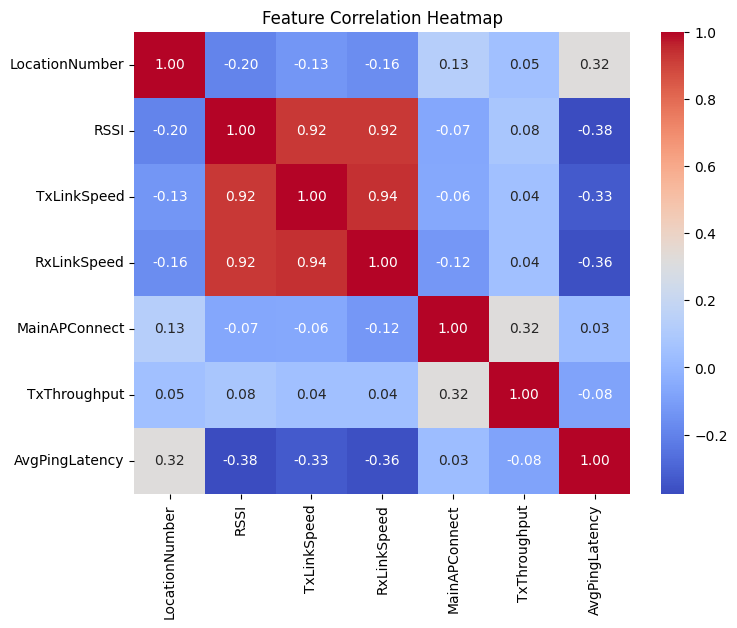

In [62]:
# Correlation analysis between features and performance metrics (TxThroughput, AvgPingLatency)

feature_cols = ['LocationNumber', 'RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect']
performance_cols = ['TxThroughput', 'AvgPingLatency']

# Compute correlation matrix between features and performance metrics
corr_matrix = train_data[feature_cols + performance_cols].corr()

# Extract correlations of features with performance metrics
corr_with_throughput = corr_matrix['TxThroughput'][feature_cols]
corr_with_latency = corr_matrix['AvgPingLatency'][feature_cols]

# Display the correlations
print("Correlation of features with TxThroughput:")
print(corr_with_throughput)
print("\nCorrelation of features with AvgPingLatency:")
print(corr_with_latency)

# Visualize correlations as bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=corr_with_throughput.index, y=corr_with_throughput.values, ax=axs[0], palette='Blues_d', hue=corr_with_throughput.index)
axs[0].set_title('Feature Correlation with TxThroughput')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].set_ylim(-1, 1)

sns.barplot(x=corr_with_latency.index, y=corr_with_latency.values, ax=axs[1], palette='Reds_d', hue=corr_with_latency.index)
axs[1].set_title('Feature Correlation with AvgPingLatency')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_ylim(-1, 1)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Part II: FNN-based WiFi Performance Prediction

## Feature Selection

In [63]:
""""
From what we have observed with the correlation analysis, 
we can see that the features that have the most correlation with the 
AvgPingLatency are:
- RSSI
- TxLinkSpeed
- RxLinkSpeed
- LocationNumber 

Also for TxThroughput we can see that the features that 
have the most correlation are:
- RSSI (is pretty low but still has more influence than the other features)
- MainAPConnect

"""

'"\nFrom what we have observed with the correlation analysis, \nwe can see that the features that have the most correlation with the \nAvgPingLatency are:\n- RSSI\n- TxLinkSpeed\n- RxLinkSpeed\n- LocationNumber \n\nAlso for TxThroughput we can see that the features that \nhave the most correlation are:\n- RSSI (is pretty low but still has more influence than the other features)\n- MainAPConnect\n\n'

## Data preparation and preprocessing

In [ ]:
"""
Data preprocessing and FNN model setup for WiFi performance prediction using PyTorch, I use pytorch because I feel more comfortable than tensorflow or Keras as I've used it before.

Steps:
1. Handle missing values
2. Feature scaling using StandardScaler
3. Split data into train/validation (test_data reserved for final evaluation)
4. Build two FNN architectures (PyTorch): one for Throughput, one for AvgPingLatency
"""

#print(train_data.isnull().sum()) # No missing values

# Prepare features and targets
# Throughput prediction
X_throughput = train_data[['RSSI', 'MainAPConnect']].copy()
y_throughput = train_data['TxThroughput']

# Latency prediction
X_latency = train_data[['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'LocationNumber']].copy()
y_latency = train_data['AvgPingLatency']


# Feature scaling
scaler_throughput = StandardScaler()
X_throughput_scaled = scaler_throughput.fit_transform(X_throughput)

scaler_latency = StandardScaler()
X_latency_scaled = scaler_latency.fit_transform(X_latency)

# Split into train/validation sets (test_data is reserved for final evaluation)
X_throughput_train, X_throughput_val, y_throughput_train, y_throughput_val = train_test_split(
    X_throughput_scaled, y_throughput, test_size=0.2, random_state=42
)
X_latency_train, X_latency_val, y_latency_train, y_latency_val = train_test_split(
    X_latency_scaled, y_latency, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_throughput_train = torch.tensor(X_throughput_train, dtype=torch.float32)
X_throughput_val = torch.tensor(X_throughput_val, dtype=torch.float32)
y_throughput_train = torch.tensor(y_throughput_train.values, dtype=torch.float32).view(-1, 1)
y_throughput_val = torch.tensor(y_throughput_val.values, dtype=torch.float32).view(-1, 1)

X_latency_train = torch.tensor(X_latency_train, dtype=torch.float32)
X_latency_val = torch.tensor(X_latency_val, dtype=torch.float32)
y_latency_train = torch.tensor(y_latency_train.values, dtype=torch.float32).view(-1, 1)
y_latency_val = torch.tensor(y_latency_val.values, dtype=torch.float32).view(-1, 1)

### FNN model setup for WiFi performance prediction using PyTorch

#### Architecture Design Justification

The FNN architecture was designed with the following considerations:

##### Network Topology
- **Input Layer**: Dimensioned to match our feature sets (2 features for throughput, 4 features for latency)
- **Hidden Layers**: Two hidden layers (32 and 16 neurons) provide sufficient complexity to capture non-linear relationships without overfitting
- **Output Layer**: Single neuron for regression output (predicting throughput or latency values)

##### Activation Functions
- **ReLU** (Rectified Linear Unit): Used for hidden layers because:
  - It addresses the vanishing gradient problem common in sigmoid/tanh activations
  - Introduces non-linearity efficiently with minimal computational cost
  - Produces sparse activations, which helps prevent overfitting
  - Works well for regression problems with positive outputs (like throughput)

##### Loss Function
- **MSE (Mean Squared Error)**: Chosen because:
  - It's the standard loss function for regression problems
  - Penalizes larger errors more heavily than smaller ones
  - Provides a differentiable gradient for optimization

##### Optimizer
- **Adam**: Selected because:
  - Combines the benefits of AdaGrad and RMSProp
  - Adapts the learning rate for each parameter
  - Works well with sparse gradients and non-stationary objectives
  - Typically requires less tuning than SGD
  - Learning rate of 0.001 provides a good balance between convergence speed and stability

##### Regularization
- **Implicit regularization**:
  - Moderate network size (32→16→1) helps prevent overfitting
  - ReLU activations produce sparse representations
  - Early stopping based on validation loss prevents overfitting

##### Model Separation vs. Multi-output
- We chose to implement separate models for throughput and latency because:
    - I found it visually easier to interpret and debug
    - Each metric has different distributions and relationships with features
    - In this case the models can be trained independently without sharing weights
    - Still we use the same architecture for both models as we are creating a basic baseline model
  

In [ ]:
class FNNThroughput(nn.Module):
    def __init__(self, input_dim):
        super(FNNThroughput, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)


class FNNLatency(nn.Module):
    def __init__(self, input_dim):
        super(FNNLatency, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)

"\n# FNN Architecture Choices\n\nThe Feedforward Neural Network (FNN) architecture for both throughput and latency predictions consists of three linear layers with ReLU activations in between. Here's the rationale behind these choices:\n\n1. **Linear Layers**: They are chosen for their simplicity and effectiveness in capturing linear relationships. Given enough data, they can also model complex nonlinear relationships.\n\n2. **ReLU Activations**: The Rectified Linear Unit (ReLU) is a popular activation function in neural networks because it introduces non-linearity into the model while being computationally efficient. It helps the network to learn complex patterns.\n\n3. **Layer Sizes**: The choice of 32 and 16 units in the hidden layers is somewhat arbitrary but is based on common practices. These sizes can capture a good amount of information while keeping the model lightweight. However, they can be tuned based on the specific dataset and problem complexity.\n\n4. **Output Layer**: T

## Model training and evaluation

Training FNNThroughput...
Epoch 1/100 - Train Loss: 121.1724 - Val Loss: 33.3004
Epoch 1/100 - Train Loss: 121.1724 - Val Loss: 33.3004
Epoch 10/100 - Train Loss: 16.9168 - Val Loss: 17.6054
Epoch 10/100 - Train Loss: 16.9168 - Val Loss: 17.6054
Epoch 20/100 - Train Loss: 16.8766 - Val Loss: 17.6819
Epoch 20/100 - Train Loss: 16.8766 - Val Loss: 17.6819
Epoch 30/100 - Train Loss: 16.8652 - Val Loss: 17.5384
Epoch 30/100 - Train Loss: 16.8652 - Val Loss: 17.5384
Epoch 40/100 - Train Loss: 16.8372 - Val Loss: 17.5094
Epoch 40/100 - Train Loss: 16.8372 - Val Loss: 17.5094
Epoch 50/100 - Train Loss: 16.7913 - Val Loss: 17.4791
Epoch 50/100 - Train Loss: 16.7913 - Val Loss: 17.4791
Epoch 60/100 - Train Loss: 16.7626 - Val Loss: 17.4582
Epoch 60/100 - Train Loss: 16.7626 - Val Loss: 17.4582
Epoch 70/100 - Train Loss: 16.7453 - Val Loss: 17.4600
Epoch 70/100 - Train Loss: 16.7453 - Val Loss: 17.4600
Epoch 80/100 - Train Loss: 16.7294 - Val Loss: 17.4577
Epoch 80/100 - Train Loss: 16.7294 - Va

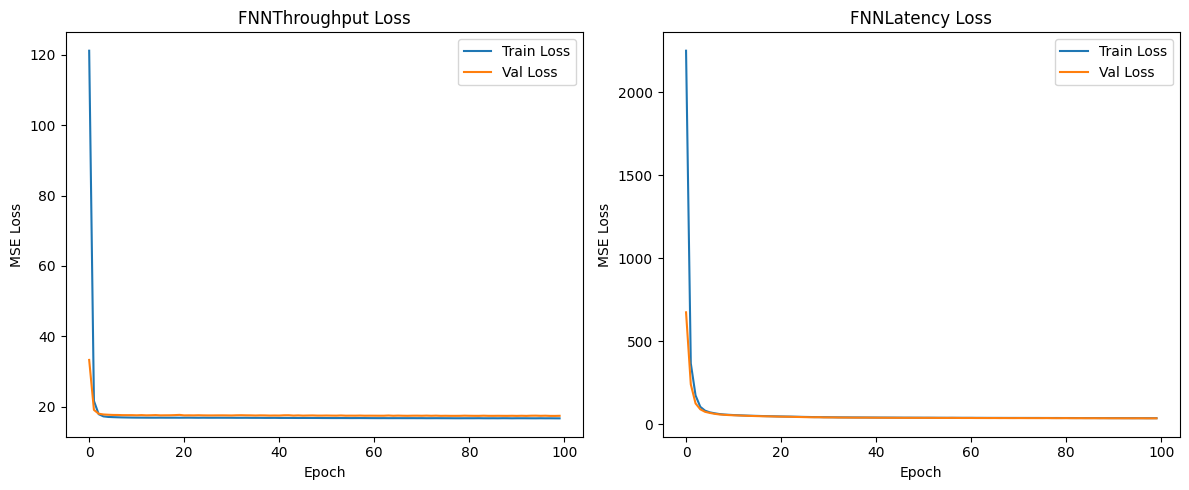

In [66]:
# Training approach:
# - We'll train both FNNThroughput and FNNLatency for 100 epochs.
# - We'll use a batch size of 128.
# - After each epoch, we'll evaluate and print the validation loss.
# - We'll store the training and validation loss history for plotting.

# Instantiate models
fnn_throughput = FNNThroughput(X_throughput_train.shape[1])
fnn_latency = FNNLatency(X_latency_train.shape[1])

loss_fn = nn.MSELoss()
optimizer_throughput = optim.Adam(fnn_throughput.parameters(), lr=0.001)
optimizer_latency = optim.Adam(fnn_latency.parameters(), lr=0.001)

# Hyperparameters
epochs = 100
batch_size = 128

# DataLoaders
train_throughput_ds = TensorDataset(X_throughput_train, y_throughput_train)
val_throughput_ds = TensorDataset(X_throughput_val, y_throughput_val)
train_latency_ds = TensorDataset(X_latency_train, y_latency_train)
val_latency_ds = TensorDataset(X_latency_val, y_latency_val)

train_throughput_loader = DataLoader(train_throughput_ds, batch_size=batch_size, shuffle=True)
val_throughput_loader = DataLoader(val_throughput_ds, batch_size=batch_size)
train_latency_loader = DataLoader(train_latency_ds, batch_size=batch_size, shuffle=True)
val_latency_loader = DataLoader(val_latency_ds, batch_size=batch_size)

def train_model(model, optimizer, train_loader, val_loader, loss_fn, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward() # Backpropagation 
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                val_loss += loss.item() * xb.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

print("Training FNNThroughput...")
throughput_train_losses, throughput_val_losses = train_model(
    fnn_throughput, optimizer_throughput, train_throughput_loader, val_throughput_loader, loss_fn, epochs
)

print("\nTraining FNNLatency...")
latency_train_losses, latency_val_losses = train_model(
    fnn_latency, optimizer_latency, train_latency_loader, val_latency_loader, loss_fn, epochs
)

# Plot training and validation loss curves

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(throughput_train_losses, label='Train Loss')
plt.plot(throughput_val_losses, label='Val Loss')
plt.title('FNNThroughput Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latency_train_losses, label='Train Loss')
plt.plot(latency_val_losses, label='Val Loss')
plt.title('FNNLatency Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model evaluation using the test set


Throughput Model Test Evaluation:
MSE: 16.7258
MAE: 3.2369
R^2: 0.1502

Latency Model Test Evaluation:
MSE: 35.1494
MAE: 4.2671
R^2: 0.5404


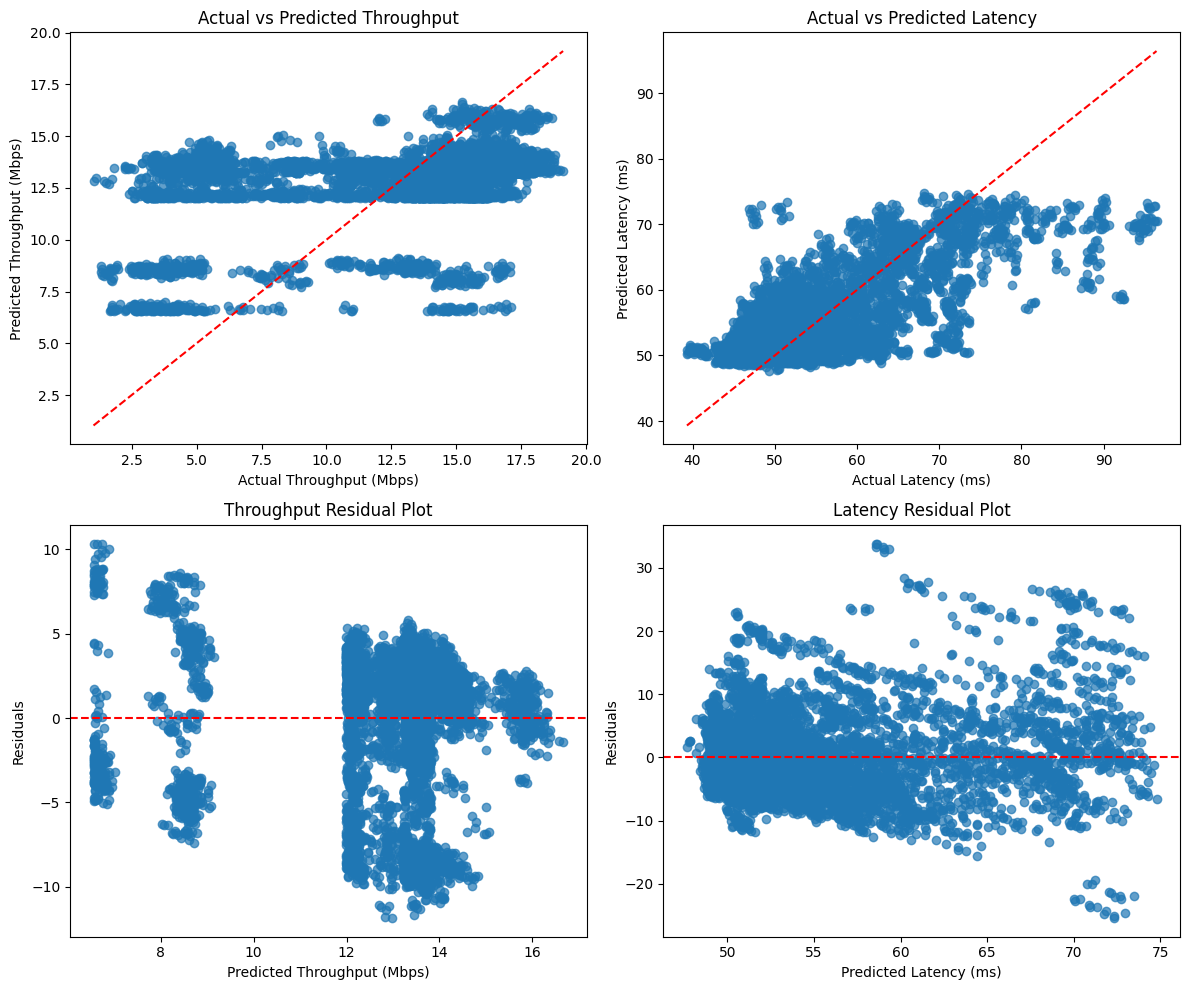

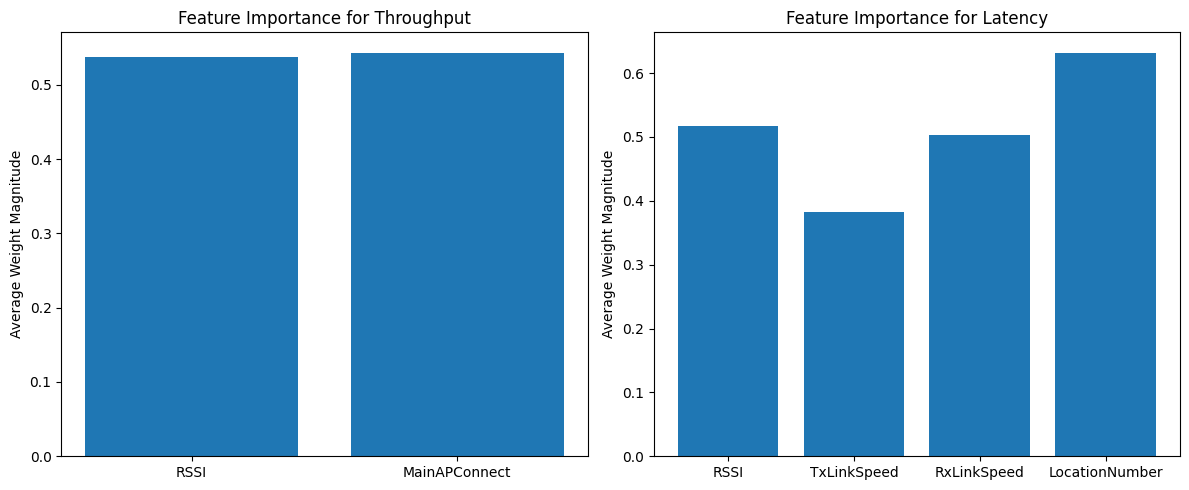

In [67]:
# Prepare test features and targets for throughput and latency
# Extract the features and targets from test data
X_test_throughput = test_data[['RSSI', 'MainAPConnect']].copy()
y_test_throughput = test_data['TxThroughput']

X_test_latency = test_data[['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'LocationNumber']].copy()
y_test_latency = test_data['AvgPingLatency']

# Apply the same scaling transformation used on training data
X_test_throughput_scaled = scaler_throughput.transform(X_test_throughput)
X_test_latency_scaled = scaler_latency.transform(X_test_latency)

# Convert to PyTorch tensors
X_test_throughput_tensor = torch.tensor(X_test_throughput_scaled, dtype=torch.float32)
X_test_latency_tensor = torch.tensor(X_test_latency_scaled, dtype=torch.float32)
y_test_throughput_tensor = torch.tensor(y_test_throughput.values, dtype=torch.float32).view(-1, 1)
y_test_latency_tensor = torch.tensor(y_test_latency.values, dtype=torch.float32).view(-1, 1)

# Set models to evaluation mode
fnn_throughput.eval()
fnn_latency.eval()

# Make predictions
with torch.no_grad():
    throughput_predictions = fnn_throughput(X_test_throughput_tensor)
    latency_predictions = fnn_latency(X_test_latency_tensor)

# Convert tensors to numpy for evaluation
throughput_true = y_test_throughput_tensor.numpy()
throughput_pred = throughput_predictions.numpy()
latency_true = y_test_latency_tensor.numpy()
latency_pred = latency_predictions.numpy()

# Calculate metrics
throughput_mse = mean_squared_error(throughput_true, throughput_pred)
throughput_mae = mean_absolute_error(throughput_true, throughput_pred)
throughput_r2 = r2_score(throughput_true, throughput_pred)

latency_mse = mean_squared_error(latency_true, latency_pred)
latency_mae = mean_absolute_error(latency_true, latency_pred)
latency_r2 = r2_score(latency_true, latency_pred)

# Print evaluation results
print(f"\nThroughput Model Test Evaluation:")
print(f"MSE: {throughput_mse:.4f}")
print(f"MAE: {throughput_mae:.4f}")
print(f"R^2: {throughput_r2:.4f}")

print(f"\nLatency Model Test Evaluation:")
print(f"MSE: {latency_mse:.4f}")
print(f"MAE: {latency_mae:.4f}")
print(f"R^2: {latency_r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 10))

# Throughput scatter plot
plt.subplot(2, 2, 1)
plt.scatter(throughput_true, throughput_pred, alpha=0.7)
plt.plot([throughput_true.min(), throughput_true.max()], 
         [throughput_true.min(), throughput_true.max()], 'r--')
plt.xlabel('Actual Throughput (Mbps)')
plt.ylabel('Predicted Throughput (Mbps)')
plt.title('Actual vs Predicted Throughput')

# Latency scatter plot
plt.subplot(2, 2, 2)
plt.scatter(latency_true, latency_pred, alpha=0.7)
plt.plot([latency_true.min(), latency_true.max()], 
         [latency_true.min(), latency_true.max()], 'r--')
plt.xlabel('Actual Latency (ms)')
plt.ylabel('Predicted Latency (ms)')
plt.title('Actual vs Predicted Latency')

# Throughput residuals
plt.subplot(2, 2, 3)
throughput_residuals = throughput_true - throughput_pred
plt.scatter(throughput_pred, throughput_residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Throughput (Mbps)')
plt.ylabel('Residuals')
plt.title('Throughput Residual Plot')

# Latency residuals
plt.subplot(2, 2, 4)
latency_residuals = latency_true - latency_pred
plt.scatter(latency_pred, latency_residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Latency (ms)')
plt.ylabel('Residuals')
plt.title('Latency Residual Plot')

plt.tight_layout()
plt.show()

# Plot feature importance (based on coefficients for linear layers)
def get_feature_importance(model, feature_names):
    # Extract weights from the first layer
    weights = model.model[0].weight.data.abs().numpy()
    # Average the absolute weights across the neurons
    importance = weights.mean(axis=0)
    return dict(zip(feature_names, importance))

# Get feature importance
throughput_features = ['RSSI', 'MainAPConnect']
latency_features = ['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'LocationNumber']

throughput_importance = get_feature_importance(fnn_throughput, throughput_features)
latency_importance = get_feature_importance(fnn_latency, latency_features)

# Plot feature importance
plt.figure(figsize=(12, 5))

# Throughput feature importance
plt.subplot(1, 2, 1)
features = list(throughput_importance.keys())
importances = list(throughput_importance.values())
plt.bar(features, importances)
plt.title('Feature Importance for Throughput')
plt.ylabel('Average Weight Magnitude')

# Latency feature importance
plt.subplot(1, 2, 2)
features = list(latency_importance.keys())
importances = list(latency_importance.values())
plt.bar(features, importances)
plt.title('Feature Importance for Latency')
plt.ylabel('Average Weight Magnitude')

plt.tight_layout()
plt.show()



## Analysis of Model Performance

Based on the evaluation metrics and scatter plots, our FNN models show different levels of performance:

### Throughput Model:
- The R² value of approximately 0.15 indicates the model explains about 15% of the variance in throughput
- MSE and MAE metrics quantify the prediction errors
- The scatter plot shows the relationship between actual and predicted values

### Latency Model:
- With an R² around 0.56, this model performs better at predicting latency than throughput
- The model explains more than half of the variance in latency
- The residual plots help visualize systematic patterns in predictions
- Points closer to the diagonal line in scatter plots indicate more accurate predictions